<h1>HOMEWORK 1</h1>

<h2 style="color:red">Introduction to Optimization</h2>

<h4>Jorge Luis Castillo Orduz</h4>
<br><br>

## Bitcoin prices and the shape of the globe

Let's begin replicating the example exercise we previously worked on. In this example we use least squares for a linear model.

First, we start importing the data stored in the provided CSV:

In [1]:
using CSV
using DataFrames

dataBitcoin = CSV.read("data/Bitcoin.csv",DataFrame);
dataBitcoin.Price .= replace.(dataBitcoin.Price, "," => "");
dataBitcoin.PriceFloat = parse.(Float64, dataBitcoin.Price);

Now, we plot this data to see how the data behaves

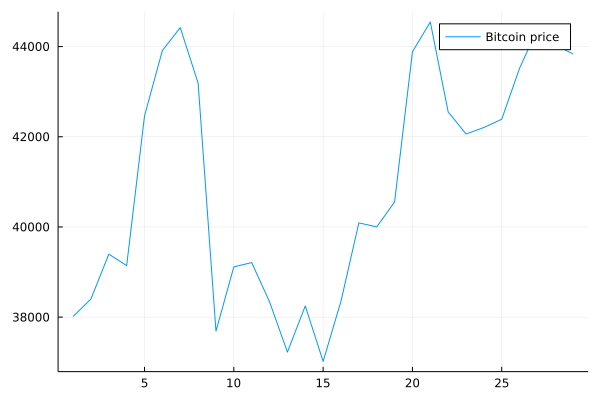

In [2]:
using Plots
plot(dataBitcoin.PriceFloat, label="Bitcoin price")

We build a solution using a linear model
<br><br>

**Least squares formulation:**

$\tilde{x} = \mbox{arg min}_{x} \| Ax - b \|_2^2$

<br>

**Least squares solution:**

$\tilde{x} = \mbox{arg min}_{x} J(\mathbf x) = \mbox{arg min}_{x} \| Ax - b \|_2^2$

$J(x) = \| Ax - b\|_2^2 = ( Ax - b )^T ( Ax - b ) = (A x)^T (A x) - (A x)^T b - b^T (A x) + b^T b$

$J(x) = x^T A^T Ax - 2 x^T A^T b + b^T b$

Now minimizing $J(x)$ w.r.t $x$:

$\frac{\partial J(x)}{\partial  x} = - 2 A^T b + 2 A^T A x = 0$

We obtain the normal equations:

$A^T A x = A^T b$
<br>
<br>

**The solution:**

$x = (A^T A)^{-1} A^T  b = A^+ b$

With $A^+ = (A^T A)^{-1} A^T$ the Moore-Penrose pseudoinverse of $A$.

Now we can define the parameters and variables we will use.

In [3]:
N = size(dataBitcoin.PriceFloat,1);
A = Array((1:N));
b = Array(dataBitcoin.PriceFloat);
A = [ones(N,1) A];

We can plot the objective function as well

In [4]:
using Plots

function f(x,y) 
    sum((A[:,1]*x+A[:,2]*y-b)*transpose((A[:,1]*x+A[:,2]*y-b)))
end
plotlyjs()
surface(-50000:1000:50000,-10000:100:15000, f)

WebIO._IJuliaInit()

We will find the solution using the QR algorithm. This algorithm can be found and easily used in the library **LinearAlgebra**.

In [5]:
using LinearAlgebra
qrA = qr(A);                    # QR decomposition
xhat = qrA\b
pred = xhat[2]*A[:,2] + xhat[1]*ones(N,1)

using Plots
plot(A[:,2],b,label="Bitcoin price")
plot!(A[:,2],pred,label="Linear Model")
yaxis!("Price")
title!("Linear Fit")

<h2> Let's Start with the Homework!</h2>
<br>

<strong><p style="font-size:20px"> 1. Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.</p></strong>

<h3 style="color:green">Answer</h3>

The number of rows of A must be the same as the number of columns of b because we need to match the amount of days <i>(# of rows of A)</i> with the amount of values we have for the Bitcoin price <i>(# of elements of b)</i>. These sets could be considered as the domain and codomain of the function we are trying to find. Additionally, if we look at the operations we make, we will notice that we need to calculate:
<ul>
    <li>Inverse Matrix(A)*b </li>
    <li>Transpose Matrix(A)*b </li>
    <li>qr(A)\b </li>
</ul>
These calculations are needed to find a solution using different methods. Thus, the common constraint we need to complete these operations is to have the same amount of rows in A as the amount of elements in b. 
<br><br>

<strong><p style="font-size:20px"> 2. Use a least squares for non-linear models adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.</p></strong>

<h3 style="color:green">Answer</h3>

I use data from 01/01/2020 to 03/15/2022 to build my models:

In [6]:
dataBitcoin2020 = CSV.read("data/Bitcoin2020.csv",DataFrame);
dataBitcoin2020.Price .= replace.(dataBitcoin2020.Price, "," => "");
dataBitcoin2020.PriceFloat = parse.(Float64, dataBitcoin2020.Price);
X = size(dataBitcoin2020.PriceFloat,1);
D = Array((1:X));
bit = Array(dataBitcoin2020.PriceFloat);

### Exponential Model

I will use the solver "LsqFit" for Julia, which according to documentation only utilizes the Levenberg-Marquardt algorithm for non-linear fitting. 

In [7]:
using LsqFit
using Plots

function exponentialModel()
    # I provide the model an initial state to start iterating
    p0 = [0.5, 0.5]      
    
    # I define the model that will be used, in this case, an exponential model
    model(t, p) = p[1] * exp.(-p[2] * t)    

    # I provide the x and y data for the model
    xdata = D
    ydata = reverse(bit)

    # I call the method to find and plot the solution
    nlin_fit(model, xdata, ydata, p0)
end

function nlin_fit(model, xdata, ydata, p0)
    # Method to find the coefficients that better fit
    nlinfit = curve_fit(model, xdata, ydata, p0)
    pfit = nlinfit.param
    println("Coefficients for the model")
    print(pfit)
    xlin = range(xdata[1], xdata[end], length=200)

    scatter(xdata, ydata, markersize=3, size = (900, 500),legend=:topright, label="Bitcoin Price")
    plot!(xlin, model(xlin, [pfit[1], pfit[2]]), linewidth=2, label="Fitted model", dpi=200)

    xaxis!("Time (days)")
    yaxis!("Price (dollars)")
    title!("Exponential fit")
end

exponentialModel()

Coefficients for the model
[13039.260430185583, -0.0019045016217290028]

Let's make some predictions to measure and plot how good or how bad our model performs.

In [8]:
# Bitcoin price for dates 03/16/2022 - 03/22/2022
realPrices = [41118.7, 40914.8, 41767.8, 42233.0, 41276.0, 41022.0, 42373.0]
dates = ["03/16/2022","03/17/2022","03/18/2022","03/19/2022","03/20/2022","03/21/2022","03/22/2022"]
# Prediction function with the cofficients we just calculated
function prediction(t)
    coeff = [13039.260430185583, -0.0019045016217290028]
    answer = coeff[1] * exp.(-coeff[2] * t)     
end

#The amount of days I used to feed my model
index = 805
errors = []
for i in 1:7
    error = abs(prediction(805+i)-realPrices[i])
    push!(errors,error)    
end
plot(dates,errors, label="Error", size = (900, 500))
xaxis!("Date")
yaxis!("Error (dollars)")
title!("Prediction errors for exponential model")

As we can see, due to the nature of our model, the prediction price will tend to increment as time passes. Let's try another aproximation for this problem.

### Polynomial Model

Let's work with a different strategy, We are going to fit a Polynomial model. We will be using the library Polynomials, which will approximate a polynomial expression with the degree we specify.

In [9]:
using Polynomials

function polynomialModel()
    xdata = D
    ydata = reverse(bit)

    poly_fit(xdata, ydata)    
end

function poly_fit(xdata, ydata)
    xlin = range(xdata[1], xdata[end])

    # plotting
    pfit2 = fit(xdata, ydata, 2)
    pfit3 = fit(xdata, ydata, 3)
    pfit5 = fit(xdata, ydata, 5)
    pfit10 = fit(xdata, ydata, 10)
    
    scatter(xdata, ydata, markersize=3, legend=:topright, label="Bitcoin Price",size = (900, 500))
    plot!(xlin, pfit2.(xlin), linewidth=2,label="f(x) = Degree 2 polynomial (x²)", color="orange")
    plot!(xlin, pfit3.(xlin), linewidth=2,label="f(x) = Degree 3 polynomial (x³)", color="red")
    plot!(xlin, pfit5.(xlin), linewidth=2,label="f(x) = Degree 5 polynomial (x⁵)", color="purple")
    plot!(xlin, pfit10.(xlin), linewidth=2,label="f(x) = Degree 10 polynomial (x¹⁰)", color="green")
    xaxis!("Time (days)")
    yaxis!("Price (dollars)")
    title!("Polynomial fit")
end

polynomialModel()

As we can see, the solution we get depends on the polynomial degree we decided to work with. One tends to think that the higher the degree the better, but that is not completely true. The reason is that we may end up overfitting, which means that we will find a solution that fits really good for the historical data but performs really bad with new data. Let's review the prediction error for these models.

In [10]:
using Polynomials

function polynomialModelErrors()
    xdata = D
    ydata = reverse(bit)
    poly_errors(xdata, ydata)    
end

function poly_errors(xdata, ydata)    
    realPrices = [41118.7, 40914.8, 41767.8, 42233.0, 41276.0, 41022.0, 42373.0]
    dates = ["03/16/2022","03/17/2022","03/18/2022","03/19/2022","03/20/2022","03/21/2022","03/22/2022"]
    
    xlin = range(xdata[1], xdata[end])
    errors2 = 
    # plotting
    pfit2 = fit(xdata, ydata, 2)
    pfit3 = fit(xdata, ydata, 3)
    pfit5 = fit(xdata, ydata, 5)
    pfit10 = fit(xdata, ydata, 10)
    index = 805
    errors2 = []
    errors3 = []
    errors5 = []
    errors10 = []
    for i in 1:7
        error2 = abs(pfit2(805+i)-realPrices[i])
        error3 = abs(pfit3(805+i)-realPrices[i])
        error5 = abs(pfit5(805+i)-realPrices[i])
        error10 = abs(pfit10(805+i)-realPrices[i])
        push!(errors2,error2)
        push!(errors3,error3)
        push!(errors5,error5)
        push!(errors10,error10)
    end
    
    plot(dates, errors2, linewidth=2,label="Errors for x²",size = (900, 500), color="orange")
    plot!(dates, errors3, linewidth=2,label="Errors for x³", color="red")
    plot!(dates, errors5, linewidth=2,label="Errors for x⁵", color="purple")
    plot!(dates, errors10, linewidth=2,label="Errors for x¹⁰", color="green")
    xaxis!("Date")
    yaxis!("Price (dollars)")
    title!("Prediction errors for polynomial models")
end

polynomialModelErrors()

We can see clearly that the error for the 10 degree polynomial model is the highest, as we guessed before. In addition to that, it seems like the error will keep rising due to the nature of the model, so this polynomial doesn't work very good. One thing to highlight is that in general, the errors for the polynomial models are stable. 

On the other hand, the best model is the model with the polynomial of degree 5.

<strong><p style="font-size:20px">3. Use least squares to determine the relationship between the bitcoin price and prices of three comodities namely, oil, silver and gold, during the last year.</p></strong>

<h3 style="color:green">Answer</h3>

We will start by getting the information required. I downloaded the data for the dates 03/24/2021 - 03/24/2022 for Bitcoin, Brent oil, silver and gold. It is important to mention that the prices for oil, silver and gold are not available for all the dates like we are used with Bitcoin. The reason is that the markets don't operate on weekends nor holidays, while we can check the price for Bitcoin without any restriction.

In [11]:
/# Reading all the data from the csv files
BitcoinYear = CSV.read("data/BitcoinYear.csv",DataFrame);
OilYear = CSV.read("data/OilYear.csv",DataFrame);
SilverYear = CSV.read("data/SilverYear.csv",DataFrame);
GoldYear = CSV.read("data/GoldYear.csv",DataFrame);

# Cleaning the data
BitcoinYear.Price .= replace.(BitcoinYear.Price, "," => "");
BitcoinYear.PriceFloat = parse.(Float64, BitcoinYear.Price);
GoldYear.Price .= replace.(GoldYear.Price, "," => "");
GoldYear.PriceFloat = parse.(Float64, GoldYear.Price);

# Joining the different tables to get the same amount of data for all
dfj1 = innerjoin(BitcoinYear, OilYear, on = [:Date], makeunique=true)
dfj2 = innerjoin(dfj1, SilverYear, on = [:Date], makeunique=true)
dfj3 = innerjoin(dfj2, GoldYear, on = [:Date], makeunique=true)

# I select and rename the columns I need
dff = select(dfj3, "PriceFloat"=>"PriceBitcoin", "Price_1"=>"PriceOil", "Price_2"=>"PriceSilver", "PriceFloat_1"=>"PriceGold")

N2 = size(dff.PriceBitcoin,1);
n_days = Array((1:N2));
A2 = reverse(dff.PriceOil);
A2 = [ones(N2,1) A2];
b2 = Array(reverse(dff.PriceBitcoin));
A3 = reverse(dff.PriceSilver);
A3 = [ones(N2,1) A3];
b3 = Array(reverse(dff.PriceBitcoin));
A4 = reverse(dff.PriceGold);
A4 = [ones(N2,1) A4];
b4 = Array(reverse(dff.PriceBitcoin));

Now we have everything we need to start modeling.

<h2 style="color:olive">OIL</h2>

First, let's review how the price of Oil behaved over the last year.

In [12]:
plot(n_days,reverse(dff.PriceOil),label="Oil price", color="olive",size = (900, 500))
xaxis!("Time (days)")
yaxis!("Price (dollars)")
title!("Historical data for Oil")

We will use the techniques we learned from the exercises above. Let's start with the linear model solved with the QR method. In this case, we replace the column of the days in the matrix A with the price for oil and repeat the same calculations. The main goal here, is to find the correlation between the price of oil and the price of Bitcoin. 

In [13]:
using LinearAlgebra
qrA2 = qr(A2);                   
xhat2 = qrA2\b2
pred2 = xhat2[2]*A2[:,2] + xhat2[1]*ones(N2,1)
using Plots
scatter(A2[:,2],b2,label="Bitcoin price",size = (900, 500), color="olive")
plot!(A2[:,2],pred2,linewidth=2,label="Linear Model", color="red")
xaxis!("Oil Price (dollars)")
yaxis!("Bitcoin Price (dollars)")
title!("Linear Model for Bitcoin price related to oil price")

In [14]:
function fitOil()
    # I provide the model an initial state to start iterating
    p0 = [0.1, 0.1]      
    
    # I define the model that will be used, in this case, an exponential model
    model(t, p) = p[1] * exp.(-p[2] * t)    

    # I provide the x and y data for the model
    xdata = reverse(dff.PriceOil)
    ydata = reverse(dff.PriceBitcoin)

    # I call the method to find and plot the solution
    nlin_fit(model, xdata, ydata, p0)
end

function nlin_fit(model, xdata, ydata, p0)
    # Method to find the coefficients that better fit
    nlinfit = curve_fit(model, xdata, ydata, p0)
    pfit = nlinfit.param
    println("Coefficients for the model")
    print(pfit)
    xlin = range(xdata[1], xdata[end])
    scatter(xdata, ydata, markersize=3, size = (900, 500),legend=:topright, label="Bitcoin Price", color="olive")
    plot!(xlin, model(xlin, [pfit[1], pfit[2]]), linewidth=2, label="Fitted model",color="red")
    xaxis!("Oil Price (dollars)")
    yaxis!("Bitcoin Price (dollars)")
    title!("Exponential Model for Bitcoin price related to oil price")
end

fitOil()

Coefficients for the model
[58868.53790783676, 0.0029645014799409932]

In [15]:
using Polynomials

function polynomialOil()
    xdata = reverse(dff.PriceOil)
    ydata = reverse(dff.PriceBitcoin)
    poly_fit(xdata, ydata)    
end

function poly_fit(xdata, ydata)
    xlin = range(xdata[1], xdata[end])

    # plotting
    pfit2 = fit(xdata, ydata, 2)
    pfit3 = fit(xdata, ydata, 3)
    pfit5 = fit(xdata, ydata, 5)
    pfit10 = fit(xdata, ydata, 10)
    
    scatter(xdata, ydata, markersize=3, legend=:topright, label="Bitcoin Price",size = (900, 500), color="olive")
    plot!(xlin, pfit2.(xlin), linewidth=2,label="f(x) = Degree 2 polynomial (x²)", color="orange")
    plot!(xlin, pfit3.(xlin), linewidth=2,label="f(x) = Degree 3 polynomial (x³)", color="red")
    plot!(xlin, pfit5.(xlin), linewidth=2,label="f(x) = Degree 5 polynomial (x⁵)", color="purple")
    plot!(xlin, pfit10.(xlin), linewidth=2,label="f(x) = Degree 10 polynomial (x¹⁰)", color="green")

    xaxis!("Oil Price (dollars)")
    yaxis!("Bitcoin Price (dollars)")
    title!("Polynomial Model for Bitcoin price related to oil price")
end

polynomialOil()

We notice immediately that the result is a completely different model. However, the intention here is to find a correlation between Bitcoin and Oil Prices. Thus, based on the models we can roughly conclude that Bitcoin price tends to go down when oil price increases. Let's see what happens with silver and gold, **but this time we will only see how the linear model behaves in order to find easily a relation.**

<h2 style="color:silver">SILVER</h2>

As we did with oil, let's review how the price of silver behaved over the last year.

In [16]:
plot(n_days,reverse(dff.PriceSilver),label="Silver price", color="gray",size = (900, 500))
xaxis!("Time (days)")
yaxis!("Price (dollars)")
title!("Historical data for Silver")

In [17]:
using LinearAlgebra
qrA3 = qr(A3);                   
xhat3 = qrA3\b3
pred3 = xhat3[2]*A3[:,2] + xhat3[1]*ones(N2,1)
using Plots
scatter(A3[:,2],b3,label="Bitcoin price",size = (900, 500), color="silver")
plot!(A3[:,2],pred3,linewidth=2,label="Linear Model")
xaxis!("Silver Price (dollars)")
yaxis!("Bitcoin Price (dollars)")
title!("Linear Model for Bitcoin price related to silver price")

We find the same behaviour for silver as we did with oil. We can conclude, from a very reductive point of view, tha the higher the price for silver, the lower the price for Bitcoin. We can start noticing that commodities and Bitcoin prices are very related.

<h2 style="color:gold">GOLD</h2>

Last but not least, lets review what happens with gold.

In [18]:
plot(n_days,reverse(dff.PriceGold),label="Gold price", color="gold",size = (900, 500))
xaxis!("Time (days)")
yaxis!("Price (dollars)")
title!("Historical data for gold")

In [19]:
using LinearAlgebra
qrA4 = qr(A4);                   
xhat4 = qrA4\b4
pred4 = xhat4[2]*A4[:,2] + xhat4[1]*ones(N2,1)
using Plots
scatter(A4[:,2],b4,label="Bitcoin price",size = (900, 500), color="gold")
plot!(A4[:,2],pred4,linewidth=2,label="Linear Model", color="blue")
xaxis!("Gold Price (dollars)")
yaxis!("Bitcoin Price (dollars)")
title!("Linear Model for Bitcoin price related to gold price")

Gold performs very similar as the two previous comodities, the higher the price for gold the lower the price for Bitcoin. However, here we note that there is an even more marked trend, which might guide us to conclue that Bitcoin is a good backup when gold is not a good option and vice versa.

# BIBLIOGRAPHY

<ul>
    <li>Julia documentation for data science: <br><a href="url">https://juliadatascience.io/</a> </li>
    <li>Least Squares for non-linear models: <br><a href="url">https://github.com/da-james/djs-office-hours/blob/master/julia-learning-src/advance/04-fitting.jl </a></li>
    <li>Julia solvers: <br><a href="url">https://julianlsolvers.github.io/LsqFit.jl/latest/</a> </li>
    <li>Julia syntaxis and general questions: <br><a href="url">https://www.geeksforgeeks.org/</a> <br><a href="url">https://stackoverflow.com/</a></li>
</ul>

